https://arxiv.org/abs/2505.04486

In [1]:
# # # download and update library
# !git clone https://github.com/Kemsekov/kemsekov_torch
# !cd kemsekov_torch && git pull

In [2]:
from matplotlib import pyplot as plt
import torch

size = 10000
X = torch.randint(0,3,(size,))*2
Y = torch.cos(X)+torch.randn_like(1.0*X)*0.1
X = torch.sin(X)+torch.randn_like(1.0*X)*0.1
domain1 = torch.stack([X,Y],-1)/2

n=2
X = torch.linspace(-torch.pi,torch.pi,size)
Y = torch.cos(X)
X = torch.sin(X)
domain2 = torch.stack([X,Y],-1)
domain2+=torch.randn_like(domain2)*0.01

domain1 = torch.concat([domain1,domain2])*4

domain2 = torch.randn_like(domain1)

domain1,domain2 = domain2,domain1

# plt.scatter(*domain1.chunk(2,-1),label='domain1')
# plt.scatter(*domain2.chunk(2,-1),label='domain2')
# plt.tight_layout()
# plt.legend()

In [3]:
import random
import numpy as np
from kemsekov_torch.train import split_dataset

class PairedDataset(torch.utils.data.Dataset):
    def __init__(self,domain1,domain2,seed=1):
        self.ind = np.array(range(len(domain1)))
        np.random.seed(seed)
        np.random.shuffle(self.ind)
        
        self.d1 = domain1
        self.d2 = domain2
    def __getitem__(self, index):
        ind1=random.randint(0,len(self.d1)-1)
        
        d1,d2 = self.d1[ind1],self.d2[index]
        return d1,d2
    def __len__(self):
        return len(self.d1)
dataset = PairedDataset(domain1,domain2)
train_dataset,test_dataset,train_loader, test_loader = split_dataset(
    dataset,
    test_size=0.05,
    batch_size=64,
    num_workers=16
)

/home/vlad/Programs/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train items 19000
Test items 1000


In [4]:
import torch.nn as nn

class FmModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5,256), #x,y + time + f_emb
            # nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,256),
            # nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,2),
        )
    def forward(self,x, f : torch.Tensor, t : torch.Tensor):
        if t.dim()==1:
            t = t[:,None]
        xt = torch.concat([x,t,f],-1)
        return self.model(xt)

class VaeModel(nn.Module):
    def __init__(self,input_dim=2,embedding_dim=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim,256),
            nn.LayerNorm(256),
            nn.GELU(),
            
            nn.Linear(256,256),
            nn.LayerNorm(256),
            nn.GELU(),
            
            nn.Linear(256,2*embedding_dim),
        )
        self.decode = nn.Sequential(
            nn.Linear(embedding_dim,256),
            nn.LayerNorm(256),
            nn.GELU(),
            
            nn.Linear(256,256),
            nn.LayerNorm(256),
            nn.GELU(),
            
            nn.Linear(256,input_dim),
        )
    def encode(self,x):
        mu,logvar = self.enc(x).chunk(2,-1)
        return mu,logvar
    
    def sample(self,mu,logvar,variance_scale : float = 1.0):
        z = torch.randn_like(mu)*logvar.exp()*variance_scale+mu
        return self.decode(z)
    
    def forward(self,x):
        mu,logvar = self.encode(x)
        s = self.sample(mu,logvar)
        return s,mu,logvar

In [ ]:
import torch.nn.functional as F
from kemsekov_torch.train import train
from kemsekov_torch.metrics import r2_score
from kemsekov_torch.common_modules import kl_divergence


beta = 1

def compute_loss_and_metric(model,batch):
    d1,d2 = batch
    rec,mu,var = model(d2)
    kl=kl_divergence(mu,var,-1)
    
    loss = F.mse_loss(d2,rec)+beta*kl
    return loss,{
        'r2':r2_score(d2,rec),
        'kl':kl
    }

epochs=10
vae = VaeModel(2,2)
optim = torch.optim.AdamW(vae.parameters(),1e-3)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(optim,len(train_loader)*epochs)

vae = train(
    vae,
    train_loader,
    test_loader,
    compute_loss_and_metric,
    'runs/flow-matching-vae',
    save_on_metric_improve=['r2'],
    num_epochs=epochs,
    optimizer=optim,
    scheduler=sch,
    accelerate_args={
        'mixed_precision':'bf16'
    },
    ema_args={
        'beta':0.999,
        'power':1
    }
)

loading runs/flow-matching-vae/checkpoints/epoch-6/state


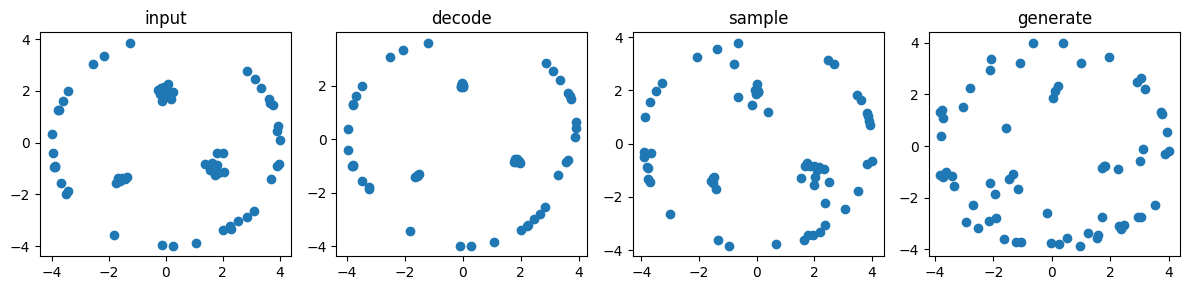

In [6]:
from kemsekov_torch.train import load_last_checkpoint,load_best_checkpoint
vae = load_best_checkpoint(vae,"runs/flow-matching-vae").cpu().eval()

for d1,d2 in test_loader:
    break

variance_scale = 1
with torch.no_grad():
    mu,var = vae.encode(d2)
    sample = vae.sample(mu,var,variance_scale)
    decode = vae.decode(mu)
    generate = vae.decode(torch.randn_like(mu))
    
plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.scatter(*d2.chunk(2,-1),label='input')
plt.title('input')
plt.subplot(1,4,2)
plt.scatter(*decode.chunk(2,-1),label='decode')
plt.title('decode')
plt.subplot(1,4,3)
plt.scatter(*sample.chunk(2,-1),label='sample')
plt.title('sample')
plt.subplot(1,4,4)
plt.scatter(*generate.chunk(2,-1))
plt.title('generate')
plt.tight_layout()

In [26]:
from kemsekov_torch.train import train
from kemsekov_torch.metrics import r2_score
from kemsekov_torch.flow_matching import FlowMatching

def get_f(d2,sample_scale=1):
    with torch.no_grad():
        vae.to(d2.device)
        mu,logvar = vae.encode(d2)
        f = torch.randn_like(mu)*logvar.exp()*sample_scale+mu
        return f

def mse(pred,target,scale=1):
    return (pred-target).pow(2).mul(scale).mean()

num_epochs=20

fm = FlowMatching()

contrast_lambda = 0.1
def compute_loss_and_metric(model,batch):
    d1,d2 = batch
    
    f = get_f(d2,0.5)
    
    def run_model(x,t):
        return model(x,f,t)
    
    pred_dir,true_dir,contrast,t = fm.contrastive_flow_matching_pair(run_model,d1,d2)

    loss = mse(pred_dir,true_dir)-contrast_lambda*mse(contrast,pred_dir)
    return loss,{
        'r2':r2_score(pred_dir,true_dir),
    }

epochs=10
m = FmModel()
optim = torch.optim.AdamW(m.parameters(),1e-2)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(optim,len(train_loader)*epochs)

train(
    m,
    train_loader,
    test_loader,
    compute_loss_and_metric,
    'runs/flow-matching',
    save_on_metric_improve=['r2'],
    num_epochs=epochs,
    optimizer=optim,
    # scheduler=sch,
    accelerate_args={
        'mixed_precision':'bf16'
    },
    ema_args={
        'beta':0.99,
        'power':1
    }
)

Total model parameters 0.07 M
Using device cuda
trying to capture model architecture...
Saved model architecture at runs/flow-matching/model.pt. You can torch.load it and update it's weights with checkpoint

Epoch 1/10


train 0: 100%|██████████| 297/297 [00:01<00:00, 232.23it/s, loss=-0.536, r2=0.8914]


+------+----------+----------+
|      |  Train   |   Test   |
+------+----------+----------+
| loss | -0.38315 | -0.63678 |
|  r2  |  0.8547  |  0.8987  |
+------+----------+----------+
saved epoch-1

Epoch 2/10


train 0: 100%|██████████| 297/297 [00:01<00:00, 232.10it/s, loss=-0.395, r2=0.8689]


+------+----------+----------+
|      |  Train   |   Test   |
+------+----------+----------+
| loss | -0.56067 | -0.64965 |
|  r2  |  0.8822  |  0.8969  |
+------+----------+----------+

Epoch 3/10


train 0: 100%|██████████| 297/297 [00:01<00:00, 224.07it/s, loss=-0.501, r2=0.8809]


+------+---------+----------+
|      |  Train  |   Test   |
+------+---------+----------+
| loss | -0.5568 | -0.57384 |
|  r2  | 0.8836  |  0.8987  |
+------+---------+----------+
saved epoch-3

Epoch 4/10


train 0: 100%|██████████| 297/297 [00:01<00:00, 206.37it/s, loss=-0.656, r2=0.8974]


+------+----------+----------+
|      |  Train   |   Test   |
+------+----------+----------+
| loss | -0.58999 | -0.68189 |
|  r2  |  0.8885  |  0.9086  |
+------+----------+----------+
saved epoch-4

Epoch 5/10


train 0: 100%|██████████| 297/297 [00:01<00:00, 222.59it/s, loss=-0.699, r2=0.8942]


+------+----------+----------+
|      |  Train   |   Test   |
+------+----------+----------+
| loss | -0.60103 | -0.69985 |
|  r2  |  0.8887  |  0.8983  |
+------+----------+----------+

Epoch 6/10


train 0: 100%|██████████| 297/297 [00:01<00:00, 223.82it/s, loss=-0.786, r2=0.9160]


+------+----------+----------+
|      |  Train   |   Test   |
+------+----------+----------+
| loss | -0.59257 | -0.69014 |
|  r2  |  0.8878  |  0.9095  |
+------+----------+----------+
saved epoch-6

Epoch 7/10


train 0: 100%|██████████| 297/297 [00:01<00:00, 226.66it/s, loss=-0.595, r2=0.8882]


+------+----------+----------+
|      |  Train   |   Test   |
+------+----------+----------+
| loss | -0.60916 | -0.70276 |
|  r2  |  0.8926  |  0.9108  |
+------+----------+----------+
saved epoch-7

Epoch 8/10


train 0: 100%|██████████| 297/297 [00:01<00:00, 240.04it/s, loss=-0.510, r2=0.8935]


+------+----------+----------+
|      |  Train   |   Test   |
+------+----------+----------+
| loss | -0.60931 | -0.75042 |
|  r2  |  0.8924  |  0.9160  |
+------+----------+----------+
saved epoch-8

Epoch 9/10


train 0: 100%|██████████| 297/297 [00:01<00:00, 224.65it/s, loss=-0.597, r2=0.8933]


+------+----------+----------+
|      |  Train   |   Test   |
+------+----------+----------+
| loss | -0.66248 | -0.74038 |
|  r2  |  0.8971  |  0.9147  |
+------+----------+----------+

Epoch 10/10


train 0: 100%|██████████| 297/297 [00:01<00:00, 231.18it/s, loss=-1.000, r2=0.9184]


+------+----------+----------+
|      |  Train   |   Test   |
+------+----------+----------+
| loss | -0.63397 | -0.73521 |
|  r2  |  0.8946  |  0.9122  |
+------+----------+----------+


FmModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [27]:
from kemsekov_torch.train import load_best_checkpoint
m = load_best_checkpoint(m,"runs/flow-matching").eval().cpu()

d1s = []
d2s = []
count = 0
for d1,d2 in train_loader:
    d1s.append(d1)
    d2s.append(d2)
    count+=1
    if count>4: break
d1 = torch.concat(d1s,0)
d2 = torch.concat(d2s,0)

loading runs/flow-matching/checkpoints/epoch-8/state


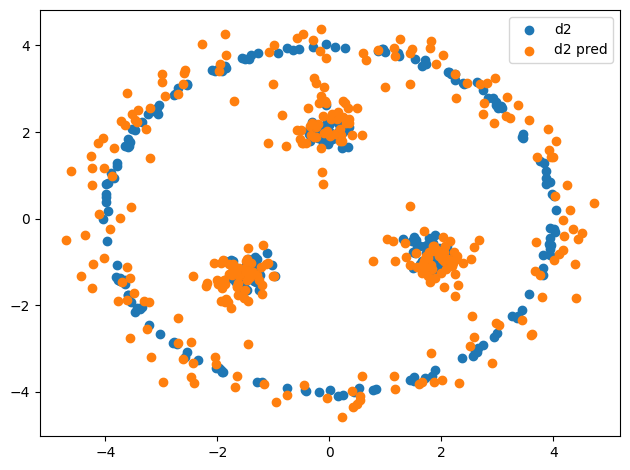

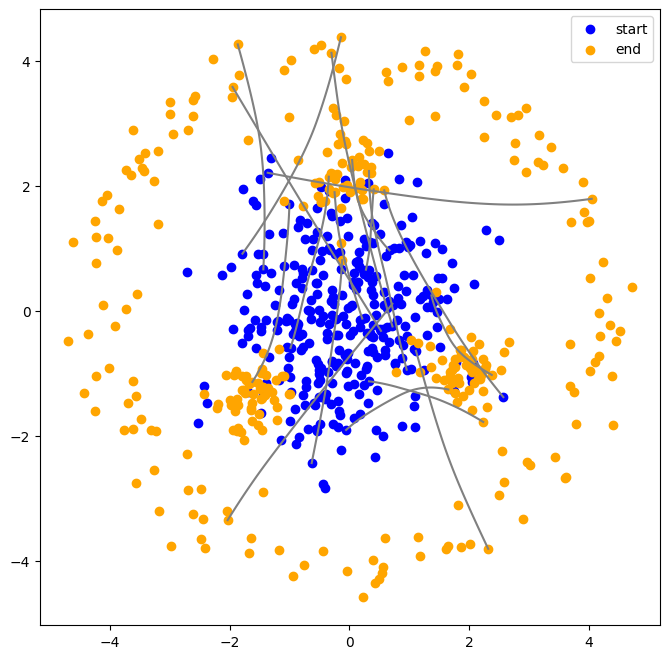

In [62]:
f = get_f(d2,1/2)
def run_model(x,t):
    return m(x,f,t)

steps=64
churn_scale=0.00
d2_pred,paths = fm.sample(run_model,d1,steps,churn_scale=churn_scale,return_intermediates=True)
# d1_pred,paths2 = fm.sample(m,d2,steps,churn_scale=churn_scale,inverse=True,return_intermediates=True)

# plt.scatter(*d1.chunk(2,-1),label='d1')
plt.scatter(*d2.chunk(2,-1),label='d2')
plt.scatter(*d2_pred.chunk(2,-1),label='d2 pred')
# plt.scatter(*d1_pred.chunk(2,-1),label='d1 pred')
plt.legend()
plt.tight_layout()
plt.show()


from random import shuffle
plt.figure(figsize=(8,8))
paths_stack = torch.stack(paths,0).transpose(0,1)

plt.scatter(*paths_stack[:,0,:].chunk(2,-1),c='blue',label='start')
plt.scatter(*paths_stack[:,-1,:].chunk(2,-1),c='orange',label='end')

for path in paths_stack:
    start = path[0]
    end = path[-1]

    if random.randint(0,10)==0:
        plt.plot(*path.chunk(2,-1),c="gray")
plt.legend()